In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix 
import warnings
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss, make_scorer
from tqdm import tqdm
import lightgbm as lgb
import gc
import datetime
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [6]:
%%time
train = pickle.load(open('C:\\Users\\USER\\Documents\\experiment\\data_model\\train_orders_merged_df_new.pkl','rb'))

Wall time: 8.7 s


In [7]:
%%time
y = train["reordered"]
X = train.drop(['product_id','order_id',"department_id","aisle_id","reordered"],axis=1)

Wall time: 10.7 s


In [8]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Wall time: 40.4 s


In [14]:
y[0:10]

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    0.0
8    1.0
9    1.0
Name: reordered, dtype: float64

In [15]:
def plot_confusion_matrix(test_y, predict_y,string):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix",string, "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [16]:
%%time
lgbm=LGBMClassifier(class_weight={0:1,1:5},learning_rate=0.1,max_depth=10,n_estimators=1200,num_leaves=63,random_state=0)
lgbm.fit(X_train,y_train)

Wall time: 11min 52s


LGBMClassifier(class_weight={0: 1, 1: 5}, max_depth=10, n_estimators=1200,
               num_leaves=63, random_state=0)

In [17]:
y_pred = lgbm.predict(X_test)
f1_score(y_test,y_pred)
# f1_score(y_test
# ,lgbm.predict(X_test),average=None),f1_score(y_test,lgbm.predict(X_test))

0.4371703369433607

Number of misclassified points  14.975797734351842
-------------------------------------------------- Confusion matrix lgbm --------------------------------------------------


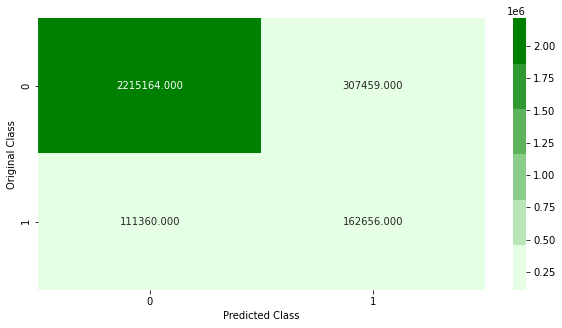

In [18]:
plot_confusion_matrix(y_test, y_pred,"lgbm")

In [4]:
%%time
# Save to file in the current working directory
pkl_filename = "C:\\Users\\USER\\Documents\\experiment\\models_more_features\\best_lgbm_new.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(lgbm, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

Wall time: 248 ms


In [11]:
len(list(X_train.columns))

72

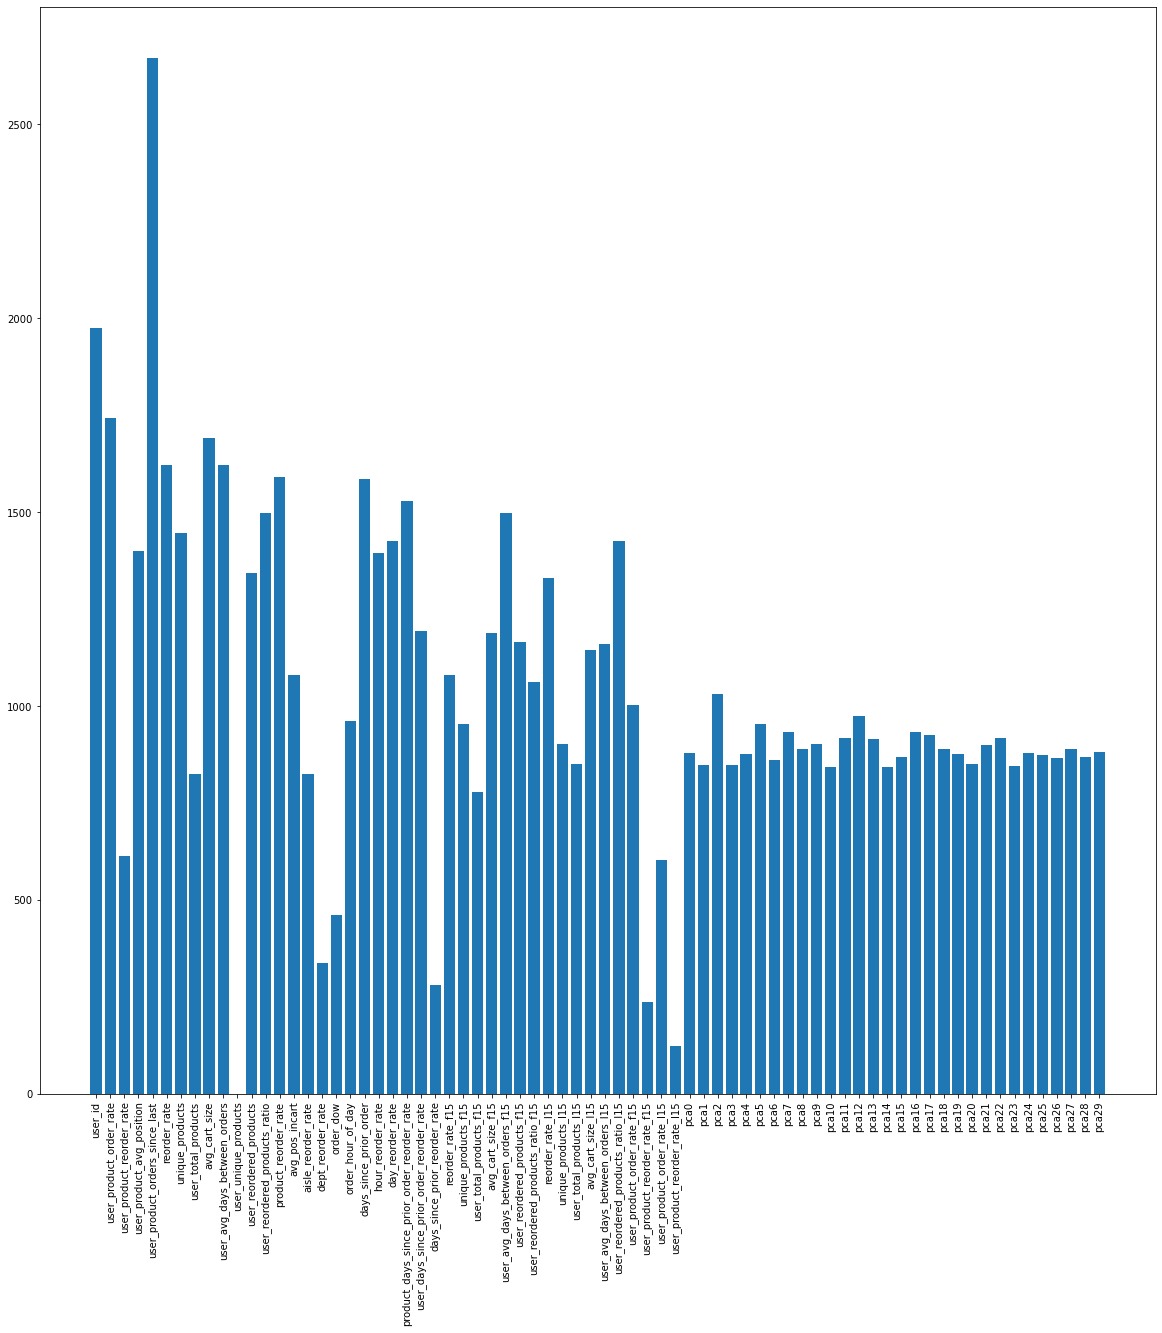

In [10]:
plt.figure(figsize=(20,20))
plt.bar(X_train.columns,pickle_model.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [34]:
!pip install mlxtend

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [35]:
%%time
best_sgd = SGDClassifier(loss="log", penalty="elasticnet", max_iter=5,alpha=0.1)
best_sgd.fit(X_train,y_train)

Wall time: 51 s


SGDClassifier(alpha=0.1, loss='log', max_iter=5, penalty='elasticnet')

In [48]:
%%time
y_pred = best_sgd.predict(X_test)
f1_score(y_test,y_pred)


Wall time: 7.35 s


0.33272059159089545

Number of misclassified points  13.070796767119388
-------------------------------------------------- Confusion matrix sgd --------------------------------------------------


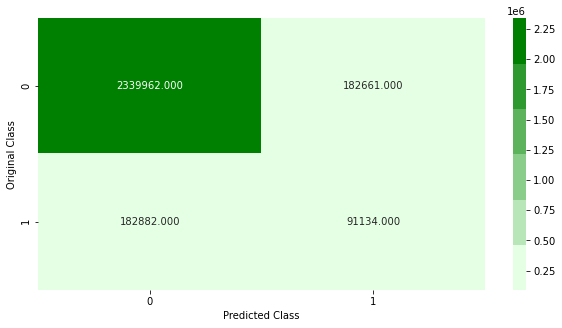

In [49]:
plot_confusion_matrix(y_test, y_pred,"sgd")

In [50]:
%%time
# Save to file in the current working directory
pkl_filename = "models_more_features/sgd.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_sgd, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

Wall time: 41.3 ms


In [39]:
%%time
from sklearn.tree import DecisionTreeClassifier
decision_tree_best = DecisionTreeClassifier(random_state=0,min_samples_split = 500, max_depth= 5)
decision_tree_best.fit(X_train,y_train)

Wall time: 6min 42s


DecisionTreeClassifier(max_depth=5, min_samples_split=500, random_state=0)

In [43]:
%%time
y_pred = decision_tree_best.predict(X_test)
f1_score(y_test,y_pred)


Wall time: 8.75 s


0.16534335908814168

Number of misclassified points  9.50998680916629
-------------------------------------------------- Confusion matrix decision tree --------------------------------------------------


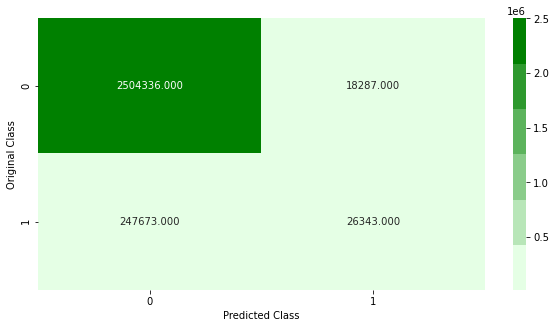

In [44]:
plot_confusion_matrix(y_test, y_pred,"decision tree")

In [45]:
%%time
# Save to file in the current working directory
pkl_filename = "models_more_features/decision_tree.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(decision_tree_best, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

Wall time: 108 ms


In [30]:
def final_result(Test,test,model):


    
    result = model.predict(test)  
    sub = pd.DataFrame({"order_id":Test["order_id"],"products":Test["product_id"],"reordered":result})
    temp = sub.groupby('order_id').agg({'reordered':'sum'}).reset_index()
    temp = temp[temp.reordered==0]
    print(len(temp))
    if len(temp)!=0:
        temp['reordered'] = ['None' for i in range(0,len(temp))]
        temp.columns = ['order_id','products']
        sub = sub[sub.reordered==1]
        sub.drop(['reordered'],axis=1,inplace=True)
        sub = sub.sort_values(by ='order_id')
        sub.order_id = sub.order_id.astype(int)
        sub["order_id"] = sub["order_id"].astype('int32')
        sub.products = sub.products.astype('str')
        sub = sub.groupby('order_id')['products'].apply(' '.join).reset_index()
        t = pd.concat([sub,temp],ignore_index=True)
    else:

        sub = sub[sub.reordered==1]
        sub.drop(['reordered'],axis=1,inplace=True)
        sub = sub.sort_values(by ='order_id')
        sub.products = sub.products.astype('str')
        sub["order_id"] = sub["order_id"].astype('int32')
        sub = sub.groupby('order_id')['products'].apply(' '.join).reset_index()
        t = sub

    return t



In [26]:
%%time
Test = pickle.load(open('data_model/test_orders_merge_df_new.pkl','rb'))
test = Test[X_train.columns]

Wall time: 2.55 s


In [31]:
%%time
df = final_result(Test,test,lgbm)

2145
Wall time: 1min 32s


In [33]:
%%time
df.to_csv("submission_files/lgbm_more.csv")

Wall time: 363 ms


In [46]:
%%time
df = final_result(Test,test,decision_tree_best)

45839
Wall time: 18 s


In [47]:
%%time
df.to_csv("submission_files/decision_tree_more.csv")

Wall time: 1.04 s


In [51]:
%%time
df = final_result(Test,test,best_sgd)

8603
Wall time: 6.66 s


In [52]:
%%time
df.to_csv("submission_files/sgd_more.csv")

Wall time: 419 ms


In [26]:
d.dtypes

order_id     int32
products    object
dtype: object

In [25]:
d["order_id"] = d["order_id"].astype('int32')

In [27]:
d.to_csv("submission_more_features.csv")